<a href="https://colab.research.google.com/github/yisiszhang/AdvancedPython/blob/main/Lecture1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 1: Learning from Data
Machine learning is a systematic search for the unknown target function that best represent the relationships between data. This lecture discusses some problems and common practice in machine learning.

The goal is to handle and explore a dataset and set it up for next steps using Python.

### Load the data
This dataset is extracted from Suzana Herculano-Houzel ”Mammalian brains are made of these”, BBE 2015, which includes measurements of brain tissue compositions and sizes cross a wide range of species.

In [2]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Read csv file into a pandas dataframe
url = 'https://raw.githubusercontent.com/yisiszhang/AdvancedPython/main/data/wholebrain_neuron.csv'
df = pd.read_csv(url, thousands=',')

# take a look a the first several rows
df.head()

,Species,Order,n,"Body mass, g","Brain mass, g",Neurons,Other cells,% Neurons,Source
0,Sorex fumeus,Eulipotyphla,3,7.8,0.176,36460000,22860000,61.3,"Sarko et al., 2009"
1,Blarina brevicauda,Eulipotyphla,5,16.2,0.347,55190000,33550000,64.8,"Sarko et al., 2009"
2,Heterocephalus glaber,Glires,3,23.3,0.392,26875462,24191205,52.5,"Herculano-Houzel et al., 2011"
3,Mus musculus,Glires,4,40.4,0.402,67873741,33858759,65.3,"Herculano-Houzel et al., 2006"
4,Parascalops breweri,Eulipotyphla,3,42.7,0.759,123600000,78260000,61.2,"Sarko et al., 2009"


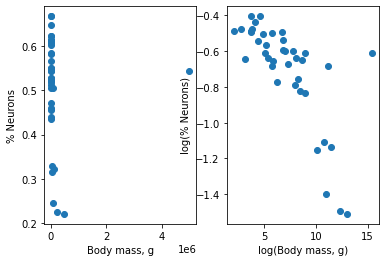

In [4]:
# take body mass and fraction of neurons and make a scatter plot
plt.subplot(1,2,1)
plt.scatter(df['Body mass, g'], df['Neurons']/(df['Neurons'] + df['Other cells']))
plt.xlabel('Body mass, g')
plt.ylabel('% Neurons')
# The data spans several orders of magnitude, we can plot in log-scale
plt.subplot(1,2,2)
plt.scatter(np.log(df['Body mass, g']), np.log(df['Neurons']/(df['Neurons'] + df['Other cells'])))
plt.xlabel('log(Body mass, g)')
plt.ylabel('log(% Neurons)')
plt.show()

### Fit the data
Statistical models can help us predict future data.
The model complexity can span from a simple linear model to various non-linear models (e.g. polynomial, networks, ...).

However, complex models can be very hard to interpret, while linear models can give us more insights.

Here we compare two models: a linear model vs a quadratic model.

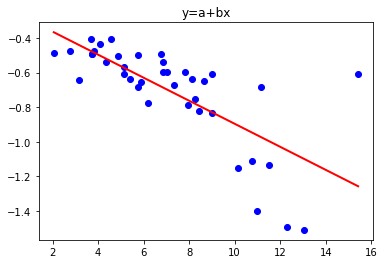

Coefficients: 
 [-0.06659798]
Mean squared error: 0.0382
Coefficient of determination: 0.52


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# what model do we choose to use for the fit?
# get x and y
x = np.array(np.log(df['Body mass, g']))
y = np.array(np.log(df['Neurons']/(df['Neurons'] + df['Other cells'])))

# x has to be a column vector (dim=2)
x = x.reshape(-1,1)

# fit the linear model
lin_reg1 = LinearRegression()
lin_reg1.fit(x, y)

# prep x,y for linear model plot
x_plot = np.linspace(np.min(x), np.max(x), 10)
x_plot = x_plot.reshape(-1,1)
y_plot = lin_reg1.predict(x_plot)

# Plot
plt.scatter(x, y,  color='blue')
plt.plot(x_plot, y_plot, 'r-', linewidth=2)
plt.title('y=a+bx')
plt.show()

# Evaluate prediction error
y_pred1 = lin_reg1.predict(x)
print('Coefficients: \n', lin_reg1.coef_)
# mean squared error
print('Mean squared error: %.4f'
      % mean_squared_error(y, y_pred1))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y, y_pred1))

Now let's try fitting a quadratic model: $y=a+bx+cx^2$

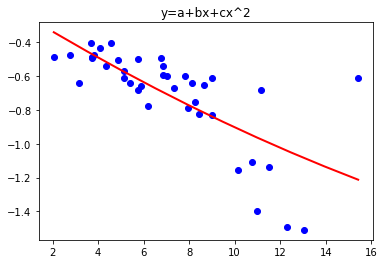

Coefficients: 
 [-0.08301135  0.00101804]
Mean squared error: 0.0380
Coefficient of determination: 0.53


In [6]:
# fit a quadratic model
X = np.hstack((x, x**2))
lin_reg2 = LinearRegression()
lin_reg2.fit(X, y)

X_plot = np.hstack((x_plot, x_plot**2))
y_plot = lin_reg2.predict(X_plot)

# Plot outputs
plt.scatter(X[:,0], y,  color='blue')
plt.plot(X_plot[:,0], y_plot, 'r-', linewidth=2)
plt.title('y=a+bx+cx^2')
plt.show()

# Make predictions using the testing set
y_pred2 = lin_reg2.predict(X)
print('Coefficients: \n', lin_reg2.coef_)
# The mean squared error
print('Mean squared error: %.4f'
      % mean_squared_error(y, y_pred2))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y, y_pred2))

### Variance-bias trade-off
Having a more complex model usually leads to more accurate prediction of the same data used for model fitting (lower bias). However, having more parameters to estimate, complex models are more sensitive to data (higher variance). And vice versa.

A more important assessment is how good a model is at predicting new data. One may find that the optimal accuracy in predicting new data is somewhere in the middle.

In the follows, we will examine the performance of polynomial models to different orders in predicting new data.


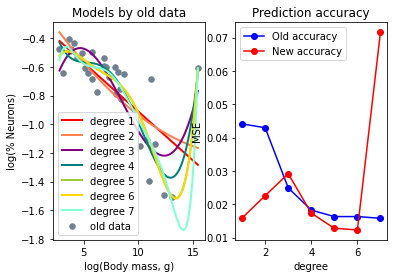

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

# Variance-bias trade-off
# randomly select 20% as new data
# choose a sequence of random numbers for replication
np.random.seed(69)  
nnew = round(len(x)*0.2)
ind_new = np.random.choice(np.arange(len(x)), nnew, replace=False)
ind_old = np.setdiff1d(np.arange(len(x)), ind_new)

x_old = x[ind_old]
y_old = y[ind_old]

x_new = x[ind_new]
y_new = y[ind_new]

# Let's make a series of models
plt.subplot(1, 2, 1)
colors = ['r', 'coral', 'purple', 'teal', 'yellowgreen', 'gold','aquamarine']
lw = 2
plt.scatter(x_old, y_old, color='slategray', s=30, marker='o', label="old data")
x_plot = np.linspace(np.min(x_old), np.max(x_old), 100)
x_plot = x_plot[:, np.newaxis] # equivalent to reshape(-1,1) here

# fit up to order of 7
nd = 7
MSE = np.zeros(nd)
MSE_training = np.zeros_like(MSE)
degrees = np.zeros_like(MSE)

for count, degree in enumerate(np.arange(1,nd+1)):
    # use the sklearn tool to generate polynomial variables (1,x,x^2,x^3,...)
    poly = PolynomialFeatures(degree)
    x_poly = poly.fit_transform(x_old)
    # each polynomial order is treated as a linear predictor, fit a multiple linear regression model
    model = linear_model.LinearRegression()
    model.fit(x_poly, y_old) 
    x_plot_poly = poly.fit_transform(x_plot)
    y_plot = model.predict(x_plot_poly)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)
    # predict the new data
    x_new_poly = poly.fit_transform(x_new)
    y_pred = model.predict(x_new_poly)
    # estimate error of new data using MSE (mean squared error)
    MSE[count] = mean_squared_error(y_new, y_pred)
    # estimate error of old data, call this MSE "MSE_training"
    y_pred = model.predict(x_poly)
    MSE_training[count] = mean_squared_error(y_old, y_pred)
    degrees[count] = degree
plt.legend(loc='lower left')
plt.xlabel('log(Body mass, g)')
plt.ylabel('log(% Neurons)')
plt.title('Models by old data')

plt.subplot(1, 2, 2)
plt.plot(degrees, MSE_training, 'bo-',label="Old accuracy")
plt.plot(degrees,MSE,'ro-',label="New accuracy")

plt.xlabel('degree')
plt.ylabel('MSE')
plt.title('Prediction accuracy')
plt.legend()
plt.rcParams["figure.figsize"] = (12,5)
plt.show()


As we can see in the right panel, more complex models give better accuracy for old data but not necessarily for new data.

### Data splitting
To assess the prediction accuracy of a model, we usually split the data into training and test sets.

The training set is used for model fitting and the test set for evaluation.

How the dataset is split matters if the sample size is relatively small, as shown in this example.

We want more training data because it will give us a more accurate estimation of the model parameters. This is traded off by losing accuracy in estimating test errors -- we also don't want a too small test set either.

In the follows, let's take a look what happens if we split the data into 90-10 vs 50-50.

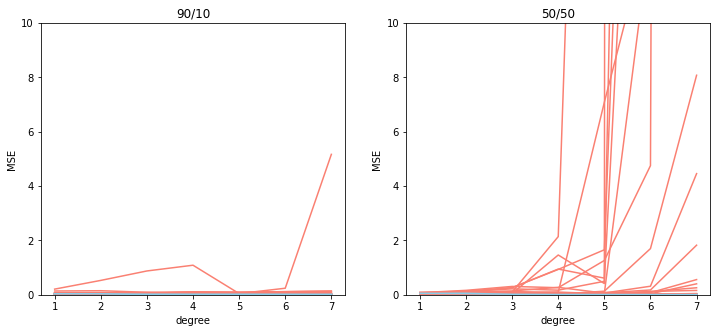

In [8]:
np.random.seed(1)

# Take a look at the behavior of variance-bias trade-off with different training/test division
# Number of trials
r = 20
nd = 7
degrees = np.arange(1,nd+1)
plt.subplot(1, 2, 1)
# divide 90/10
for ri in range(r):
  nnew = round(len(x)*0.1)
  ind_new = np.random.choice(np.arange(len(x)), nnew, replace=False)
  ind_old = np.setdiff1d(np.arange(len(x)), ind_new)

  x_old = x[ind_old]
  y_old = y[ind_old]

  x_new = x[ind_new]
  y_new = y[ind_new]

  MSE = np.zeros(nd)
  MSE_training = np.zeros_like(MSE)

  for count, degree in enumerate(np.arange(1,nd+1)):
      poly = PolynomialFeatures(degree)
      x_poly = poly.fit_transform(x_old)
      model = linear_model.LinearRegression()
      model.fit(x_poly, y_old) 
      x_new_poly = poly.fit_transform(x_new)
      y_pred = model.predict(x_new_poly)
      MSE[count] = mean_squared_error(y_new, y_pred)
      y_pred = model.predict(x_poly)
      MSE_training[count] = mean_squared_error(y_old, y_pred)
  plt.plot(degrees, MSE, color='salmon')
  plt.plot(degrees,MSE_training, color='skyblue')

plt.xlabel('degree')
plt.ylabel('MSE')
plt.title('90/10')
plt.ylim((0,10))

plt.subplot(1, 2, 2)
# divide 50/50
for ri in range(r):
  nnew = round(len(x)*0.5)
  ind_new = np.random.choice(np.arange(len(x)), nnew, replace=False)
  ind_old = np.setdiff1d(np.arange(len(x)), ind_new)

  x_old = x[ind_old]
  y_old = y[ind_old]

  x_new = x[ind_new]
  y_new = y[ind_new]

  MSE = np.zeros(nd)
  MSE_training = np.zeros_like(MSE)

  for count, degree in enumerate(np.arange(1,nd+1)):
      poly = PolynomialFeatures(degree)
      x_poly = poly.fit_transform(x_old)
      model = linear_model.LinearRegression()
      model.fit(x_poly, y_old) 
      x_new_poly = poly.fit_transform(x_new)
      y_pred = model.predict(x_new_poly)
      MSE[count] = mean_squared_error(y_new, y_pred)
      y_pred = model.predict(x_poly)
      MSE_training[count] = mean_squared_error(y_old, y_pred)
  plt.plot(degrees, MSE, color='salmon')
  plt.plot(degrees,MSE_training, color='skyblue')

plt.xlabel('degree')
plt.ylabel('MSE')
plt.title('50/50')
plt.ylim((0,10))
plt.rcParams["figure.figsize"] = (12,5)
plt.show()


Comparing the right panel with the left, the MSE becomes very volatile in the 50-50 case as the model becomes more complex. This is due to the inadequacy of coverage of training data in the 50-50 case. Too many data points out of prediction range can make the model very off. We usually choose a 80/20 or 90/10 split.

sklearn has a built-in function to split the data.

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2)

### Numerical vs. Categorical Data
Sometimes we deal with categorical data that cannot be quantified. What do we do with them?

One may want to make predictions of categories in the case of classification (a type of supervised learning).

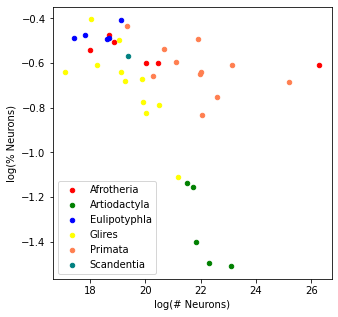

In [34]:
df['Order '] = df['Order '].astype("category")
df['log Neurons'] = np.log(df['Neurons'])
df['log % Neurons'] = np.log(df['Neurons']/(df['Neurons'] + df['Other cells']))
# Map orders to the colors
colors={'Afrotheria':'red', 'Artiodactyla':'green', 'Eulipotyphla':'blue', 'Glires':'yellow', 'Primata':'coral', 'Scandentia':'teal'}

# Finally plot orders by different colors
grouped = df.groupby('Order ')
fig, ax = plt.subplots()
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='log Neurons', y='log % Neurons', label=key, color=colors[key])

plt.xlabel('log(# Neurons)')
plt.ylabel('log(% Neurons)')
plt.rcParams["figure.figsize"] = (5,5)
plt.show()

Let's try regression vs. classification models:

(1) A linear regression of log(% neurons) vs log(# neurons)

(2) A classification of "Orders" based on the above two features

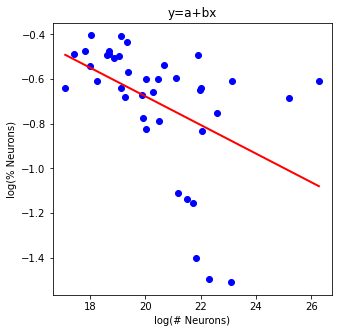

In [22]:
from sklearn.linear_model import LinearRegression

# get x and y
x1 = np.array(df['log Neurons'])
x2 = np.array(df['log % Neurons'])
x1 = x1.reshape(-1,1)
x2 = x2.reshape(-1,1)

# linear regression
# fit the linear model
lin_reg1 = LinearRegression()
lin_reg1.fit(x1, x2)

# prep x,y for linear model plot
x_plot = np.linspace(np.min(x1), np.max(x1), 10)
x_plot = x_plot.reshape(-1,1)
y_plot = lin_reg1.predict(x_plot)

# Plot
plt.scatter(x1, x2,  color='blue')
plt.plot(x_plot, y_plot, 'r-', linewidth=2)
plt.title('y=a+bx')
plt.xlabel('log(# Neurons)')
plt.ylabel('log(% Neurons)')
plt.show()

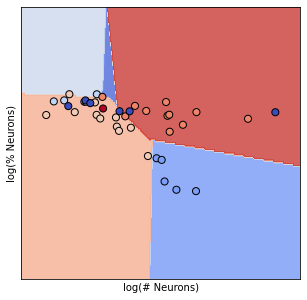

In [36]:
from sklearn import svm
# classification
X = np.hstack((x1, x2))
y = df['Order '].cat.codes
clf = svm.SVC(kernel='linear', C=10)
clf.fit(X, y)

ax = plt.gca()
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy
 
 
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out
 
xx, yy = make_meshgrid(x1,x2)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(x1, x2, c=y, cmap=plt.cm.coolwarm, s=50, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
plt.xlabel('log(# Neurons)')
plt.ylabel('log(% Neurons)')
ax.set_xticks(())
ax.set_yticks(())
 
plt.show()


### Supervised vs. Unsupervised learning

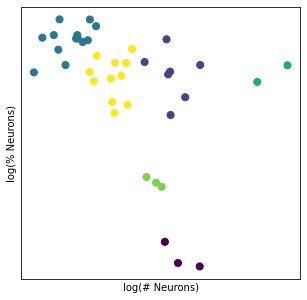

In [46]:
from sklearn import preprocessing
from sklearn.cluster import KMeans

# scale X
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
kmeans = KMeans(n_clusters=6, random_state=0).fit(X_scaled)

plt.scatter(x1, x2, c=kmeans.labels_, s=50)
plt.xlabel('log(# Neurons)')
plt.ylabel('log(% Neurons)')
ax = plt.gca()
ax.set_xticks(())
ax.set_yticks(())
plt.show()

# Homework
1. Data splitting. Try with different random number seeds and splitting strategies to see if you get consistent results. Decide how you would split the data.
2. Decide which polynomial model to use and write down your rationale.